In [1]:
import torch
import numpy as np
import torch.nn as nn

import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Using cuda device
Epoch: 0, Loss: 0.010979
Epoch: 100, Loss: 0.656706
Epoch: 200, Loss: 0.643186
Epoch: 300, Loss: 0.655287
Epoch: 400, Loss: 0.562984
Epoch: 500, Loss: 0.568788
Epoch: 600, Loss: 0.543236
Epoch: 700, Loss: 0.530538
Epoch: 800, Loss: 0.514413
Epoch: 900, Loss: 0.481512
Epoch: 1000, Loss: 0.455133
Epoch: 1100, Loss: 0.624786
Epoch: 1200, Loss: 0.579989
Epoch: 1300, Loss: 0.539915
Epoch: 1400, Loss: 0.499618
Epoch: 1500, Loss: 0.461130
Epoch: 1600, Loss: 0.427749
Epoch: 1700, Loss: 0.389558
Epoch: 1800, Loss: 0.363422
Epoch: 1900, Loss: 0.328877
Epoch: 2000, Loss: 0.307759
Epoch: 2100, Loss: 0.659646
Epoch: 2200, Loss: 0.685627
Epoch: 2300, Loss: 0.749291
Epoch: 2400, Loss: 0.643549
Epoch: 2500, Loss: 0.674206
Epoch: 2600, Loss: 0.606316
Epoch: 2700, Loss: 0.598210
Epoch: 2800, Loss: 0.528737
Epoch: 2900, Loss: 0.539926
Epoch: 3000, Loss: 0.238901
Epoch: 3100, Loss: 0.199210
Epoch: 3200, Loss: 0.163118
Epoch: 3300, Loss: 0.179281
Epoch: 3400, Loss: 0.149468
Epoch: 3500, L

Text(0.5, 1.0, 'Grad Norm')

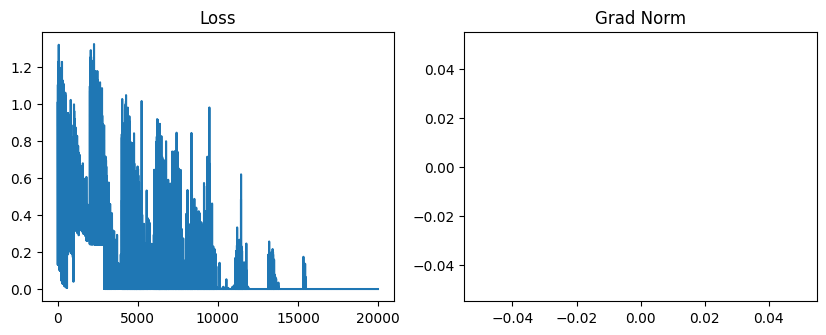

In [6]:
D = 20
L = 1000
N = 10
batchsize = 1
epochs = 20000
lr = 100
temperature = 1/25

torch.random.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

translations = []
for d in range(D):
    P = np.random.permutation(np.eye(N**2))
    translations.append(torch.tensor(P).float().to(device))

shifted_inds = [L-1] + list(range(0, L-1))
shift_mat = torch.zeros(L, L)
for i in range(L):
    shift_mat[i, shifted_inds[i]] = 1
shift_mat = shift_mat.unsqueeze(0).to(device)

I_n = torch.eye(N)
Ones_n = torch.ones(N, 1)
P1 = torch.kron(I_n, Ones_n)
P2 = torch.kron(Ones_n, I_n)
Q = (P1 @ P2.T).unsqueeze(0).to(device)
Q_t = Q.transpose(1, 2)
vocab = [chr(i) for i in range(97, 97 + N)]

def decode(mat):
    ret = []
    for i in range(len(mat[0])):
        ind = torch.argmax(mat[:, i])
        char1 = vocab[ind // N]
        char2 = vocab[ind % N]
        ret.append(char1 + char2)
    return ret

def decode_dict(D):
    for i in range(len(D)):
        input_ind = torch.argmax(D[i])
        output_ind = i
        print(vocab[input_ind // N] + vocab[input_ind % N] + " -> " + vocab[output_ind // N] + vocab[output_ind % N])

def shift(input_mat):
    shifted_input_mat = torch.matmul(input_mat, shift_mat)
    left = Q @ input_mat
    right = Q_t @ shifted_input_mat
    return left * right

def MLT(input_mat, dictionaries):

    ret = input_mat
    # print(ret)
    for D in dictionaries:
        # print(decode(ret[0]))
        ret = D @ ret
        ret = shift(ret)
        # decode_dict(D)
        # print(decode(ret[0]))
    return ret

weight_dicts = []
for i in range(D):
    # weight_dict = torch.zeros_like(translations[i])
    weight_dict = torch.randn_like(translations[i]) / N
    # weight_dict += 1/N**2
    weight_dict.requires_grad = True
    weight_dicts.append(weight_dict)

def create_mask(gt_dict, mask_inds):
    mask = gt_dict.clone()
    for i in range(len(mask_inds)):
        mask[:, mask_inds[i]] = 0
    return mask

# mask_ind = 0
random_seq = np.random.choice(N**2, (batchsize, L))
input_batch = (F.one_hot(torch.tensor(random_seq), N**2).float().transpose(-1, -2)).to(device)
with torch.no_grad():
    label_batch = MLT(input_batch, translations)

loss_record = []
grad_norm = []
weight_acc = [[] for i in range(D)]
loss_accum = 0

for i in range(epochs):
    iter_inds = i % N**2
    layer_ind = (i // N**2) % D

    masked_dict_seq = []
    for j in range(D):
        if j == layer_ind:
            tmp_mask = create_mask(translations[j], [iter_inds])
        else:
            tmp_mask = create_mask(translations[j], [])
        
        effective_weight = F.softmax((weight_dicts[j] + tmp_mask) / temperature, dim=0)
        masked_dict_seq.append(effective_weight)

    output = MLT(input_batch, masked_dict_seq)

    output_flatten = torch.cat([x for x in output], dim=1).T
    label_flatten = torch.cat([x for x in label_batch], dim=1).T
    
    for j in range(D):
        weight_max = torch.argmax(weight_dicts[j], dim=0)
        gt_max = torch.argmax(translations[j], dim=0)
        weight_acc[j].append(torch.sum(weight_max == gt_max).item() / N**2)

    loss = torch.mean((output - label_batch) ** 2)
    loss = F.cross_entropy(torch.log(output_flatten + 1e-10), torch.argmax(label_flatten, dim=1))
    loss.backward()

    loss_accum += loss.item()
    loss_record.append(loss.item())
    
    if i % 100 == 0:
        print("Epoch: %d, Loss: %f" % (i, loss_accum / 100))
        loss_accum = 0

    # for j in range(D):
    #     with torch.no_grad():
    #         weight_dicts[j] -= lr * weight_dicts[j].grad
    #         weight_dicts[j].grad.zero_()
    #         weight_dicts[j].clip_(0, 1)

    with torch.no_grad():
        weight_dicts[layer_ind] -= lr * weight_dicts[layer_ind].grad
        weight_dicts[layer_ind].clip_(0, 1)
        for j in range(D):
            weight_dicts[j].grad.zero_()

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(loss_record)
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(grad_norm)
plt.title("Grad Norm")

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

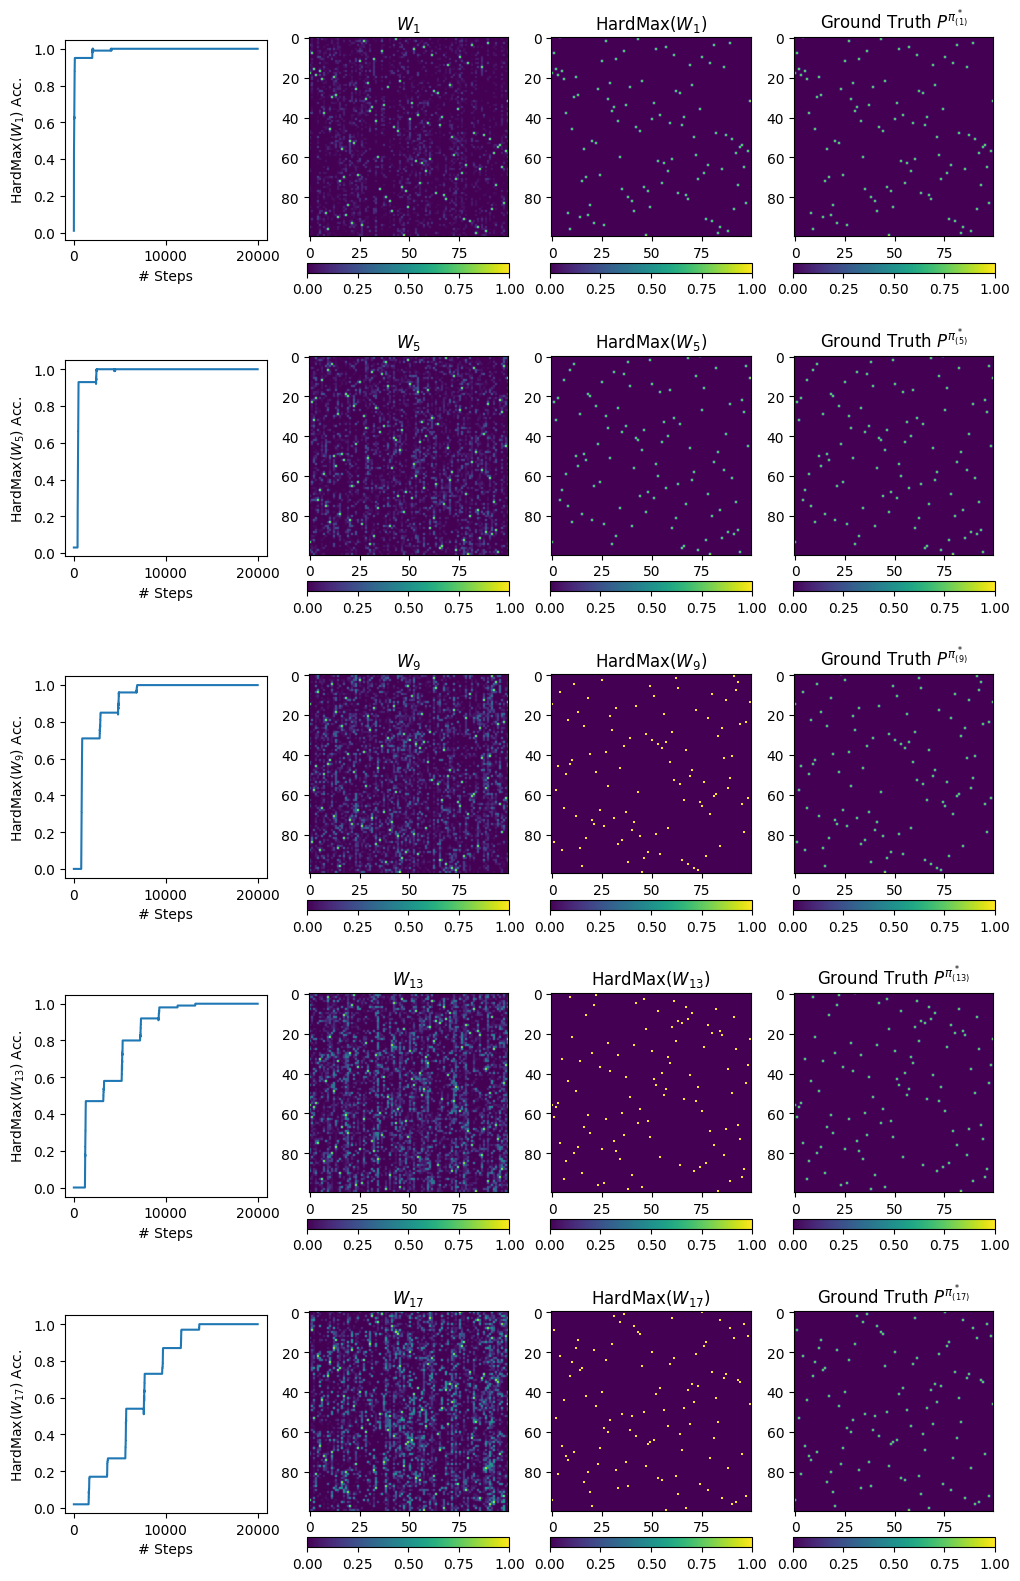

In [11]:
stepsize = 4
plt.figure(figsize=(12, 4*D // stepsize), dpi=100)
gs = gridspec.GridSpec(D // stepsize, 4)
for pi, i in enumerate(range(0, D, stepsize)):

    ax = plt.subplot(gs[pi, 0])
    ax.set_aspect(20000 ,adjustable='box')
    ax.plot(weight_acc[i], label="Layer %d" % i)
    ax.set_ylabel(r"HardMax($W_{{XXX}}$) Acc.".replace("XXX", str(i + 1)))
    ax.set_xlabel("# Steps")
    pos = ax.get_position()  # Get current position
    ax.set_position([pos.x0, pos.y0 + 0.015, pos.width, pos.height])  # Adjust y0

    ax = plt.subplot(gs[pi, 1])
    ax.set_title(r"$W_{{XXX}}$".replace("XXX", str(i + 1)))
    im = ax.imshow(weight_dicts[i].detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

    ax = plt.subplot(gs[pi, 2])
    ax.set_title(r"HardMax($W_{{XXX}}$)".replace("XXX", str(i + 1)))
    im = ax.imshow(torch.softmax(100*weight_dicts[i], dim=1).detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

    ax = plt.subplot(gs[pi, 3])
    ax.set_title(r"Ground Truth $P^{\pi^*_{(XXX)}}$".replace("XXX", str(i + 1)))
    im = ax.imshow(translations[i].detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

# plt.tight_layout()
plt.savefig("./figs/N10D20L1000_layerwise.pdf", bbox_inches='tight', pad_inches=0)
# plt.figure(figsize=(10, 3.5))
# plt.subplot(1, 3, 1)
# plt.title("Ground Truth")
# plt.imshow(translations[0].detach().cpu().numpy())
# plt.colorbar()
# plt.subplot(1, 3, 2)
# plt.title("Weight")
# plt.imshow(weight_dict1.detach().cpu().numpy())
# plt.colorbar()
# plt.subplot(1, 3, 3)
# plt.title("Effective Matrix")
# plt.imshow(F.softmax(10 * (weight_dict1), dim=0).detach().cpu().numpy())
# plt.colorbar()
plt.show()


In [12]:
weight_acc_layerwise = np.array(weight_acc)

Using cuda device
Epoch: 0, Loss: 0.013018
Epoch: 100, Loss: 0.583595
Epoch: 200, Loss: 0.543723
Epoch: 300, Loss: 0.600258
Epoch: 400, Loss: 0.603417
Epoch: 500, Loss: 0.546054
Epoch: 600, Loss: 0.525883
Epoch: 700, Loss: 0.496218
Epoch: 800, Loss: 0.473318
Epoch: 900, Loss: 0.432612
Epoch: 1000, Loss: 0.400134
Epoch: 1100, Loss: 0.366079
Epoch: 1200, Loss: 0.328125
Epoch: 1300, Loss: 0.293608
Epoch: 1400, Loss: 0.263382
Epoch: 1500, Loss: 0.223794
Epoch: 1600, Loss: 0.190421
Epoch: 1700, Loss: 0.155987
Epoch: 1800, Loss: 0.126254
Epoch: 1900, Loss: 0.086462
Epoch: 2000, Loss: 0.070005
Epoch: 2100, Loss: 0.463821
Epoch: 2200, Loss: 0.469087
Epoch: 2300, Loss: 0.525337
Epoch: 2400, Loss: 0.560744
Epoch: 2500, Loss: 0.499985
Epoch: 2600, Loss: 0.492095
Epoch: 2700, Loss: 0.455581
Epoch: 2800, Loss: 0.432594
Epoch: 2900, Loss: 0.392872
Epoch: 3000, Loss: 0.355224
Epoch: 3100, Loss: 0.314871
Epoch: 3200, Loss: 0.274742
Epoch: 3300, Loss: 0.234484
Epoch: 3400, Loss: 0.203773
Epoch: 3500, L

Text(0.5, 1.0, 'Grad Norm')

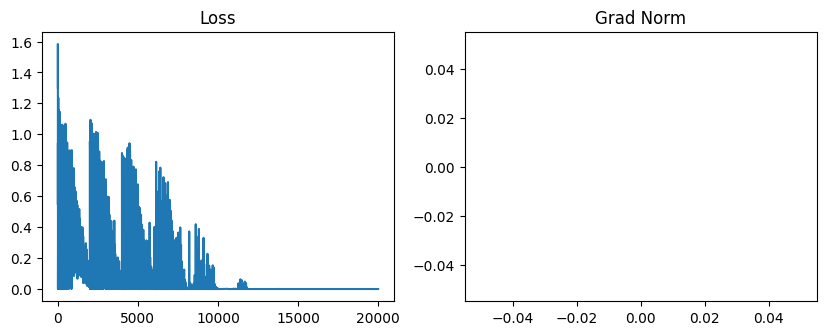

In [13]:
D = 20
L = 1000
N = 10
batchsize = 1
epochs = 20000
lr = 100
temperature = 1/25

torch.random.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

translations = []
for d in range(D):
    P = np.random.permutation(np.eye(N**2))
    translations.append(torch.tensor(P).float().to(device))

shifted_inds = [L-1] + list(range(0, L-1))
shift_mat = torch.zeros(L, L)
for i in range(L):
    shift_mat[i, shifted_inds[i]] = 1
shift_mat = shift_mat.unsqueeze(0).to(device)

I_n = torch.eye(N)
Ones_n = torch.ones(N, 1)
P1 = torch.kron(I_n, Ones_n)
P2 = torch.kron(Ones_n, I_n)
Q = (P1 @ P2.T).unsqueeze(0).to(device)
Q_t = Q.transpose(1, 2)
vocab = [chr(i) for i in range(97, 97 + N)]

def decode(mat):
    ret = []
    for i in range(len(mat[0])):
        ind = torch.argmax(mat[:, i])
        char1 = vocab[ind // N]
        char2 = vocab[ind % N]
        ret.append(char1 + char2)
    return ret

def decode_dict(D):
    for i in range(len(D)):
        input_ind = torch.argmax(D[i])
        output_ind = i
        print(vocab[input_ind // N] + vocab[input_ind % N] + " -> " + vocab[output_ind // N] + vocab[output_ind % N])

def shift(input_mat):
    shifted_input_mat = torch.matmul(input_mat, shift_mat)
    left = Q @ input_mat
    right = Q_t @ shifted_input_mat
    return left * right

def MLT(input_mat, dictionaries):

    ret = input_mat
    # print(ret)
    for D in dictionaries:
        # print(decode(ret[0]))
        ret = D @ ret
        ret = shift(ret)
        # decode_dict(D)
        # print(decode(ret[0]))
    return ret

weight_dicts = []
for i in range(D):
    # weight_dict = torch.zeros_like(translations[i])
    weight_dict = torch.randn_like(translations[i]) / N
    # weight_dict += 1/N**2
    weight_dict.requires_grad = True
    weight_dicts.append(weight_dict)

def create_mask(gt_dict, mask_inds):
    mask = gt_dict.clone()
    for i in range(len(mask_inds)):
        mask[:, mask_inds[i]] = 0
    return mask

# mask_ind = 0
random_seq = np.random.choice(N**2, (batchsize, L))
input_batch = (F.one_hot(torch.tensor(random_seq), N**2).float().transpose(-1, -2)).to(device)
with torch.no_grad():
    label_batch = MLT(input_batch, translations)

loss_record = []
grad_norm = []
weight_acc = [[] for i in range(D)]
loss_accum = 0

for i in range(epochs):
    iter_inds = i % N**2
    layer_ind = (i // N**2) % D

    masked_dict_seq = []
    for j in range(D):
        if j == layer_ind:
            tmp_mask = create_mask(translations[j], [iter_inds])
        else:
            tmp_mask = create_mask(translations[j], [])
        
        effective_weight = F.softmax((weight_dicts[j] + tmp_mask) / temperature, dim=0)
        masked_dict_seq.append(effective_weight)

    output = MLT(input_batch, masked_dict_seq)

    output_flatten = torch.cat([x for x in output], dim=1).T
    label_flatten = torch.cat([x for x in label_batch], dim=1).T
    
    for j in range(D):
        weight_max = torch.argmax(weight_dicts[j], dim=0)
        gt_max = torch.argmax(translations[j], dim=0)
        weight_acc[j].append(torch.sum(weight_max == gt_max).item() / N**2)

    loss = torch.mean((output - label_batch) ** 2)
    loss = F.cross_entropy(torch.log(output_flatten + 1e-10), torch.argmax(label_flatten, dim=1))
    loss.backward()

    loss_accum += loss.item()
    loss_record.append(loss.item())
    
    if i % 100 == 0:
        print("Epoch: %d, Loss: %f" % (i, loss_accum / 100))
        loss_accum = 0

    for j in range(D):
        with torch.no_grad():
            weight_dicts[j] -= lr * weight_dicts[j].grad
            weight_dicts[j].grad.zero_()
            weight_dicts[j].clip_(0, 1)

    # with torch.no_grad():
    #     weight_dicts[layer_ind] -= lr * weight_dicts[layer_ind].grad
    #     weight_dicts[layer_ind].grad.zero_()
    #     weight_dicts[layer_ind].clip_(0, 1)

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(loss_record)
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(grad_norm)
plt.title("Grad Norm")

In [14]:
weight_acc_nonlayerwise = np.array(weight_acc)

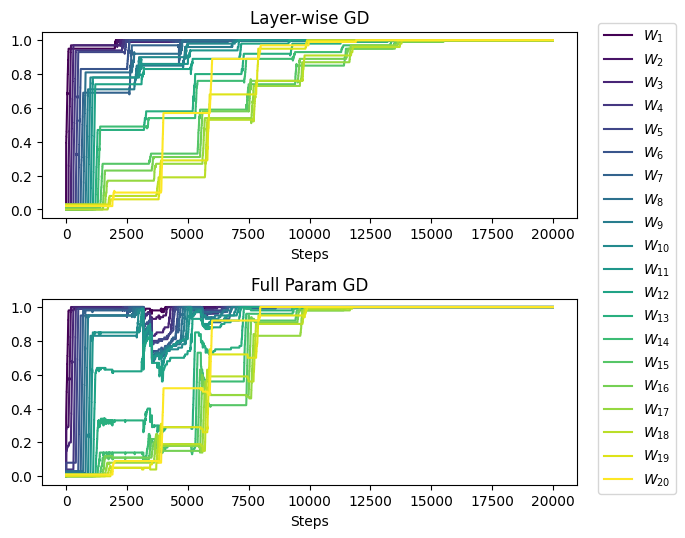

In [28]:

colors = plt.cm.viridis(np.linspace(0, 1, D))

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.1])
figure = plt.figure(figsize=(7, 5.5))
ax1 = plt.subplot(gs[0, 0])

for i in range(D):
    ax1.plot(weight_acc_layerwise[i], label=r"$W_{{%d}}$" % (i+1), color=colors[i])
# ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')
# ax.set_title(r"Accuracy of HardMax($W_i$) vs $W_i^*$")
ax1.set_title(r"Layer-wise GD")
ax1.set_xlabel("Steps")

ax2 = plt.subplot(gs[1, 0])
for i in range(D):
    ax2.plot(weight_acc_nonlayerwise[i], label=r"$W_{{%d}}$" % (i+1), color=colors[i])
# ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')
ax2.set_title(r"Full Param GD")
ax2.set_xlabel("Steps")

ax3 = plt.subplot(gs[:,1])
ax3.axis('off')  # Turn off the axis

# Add the legend
ax3.legend(*ax2.get_legend_handles_labels(), loc='center', ncol=1)
plt.tight_layout()
plt.savefig("./figs/N10D20_layerwise_vs_fullparam.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

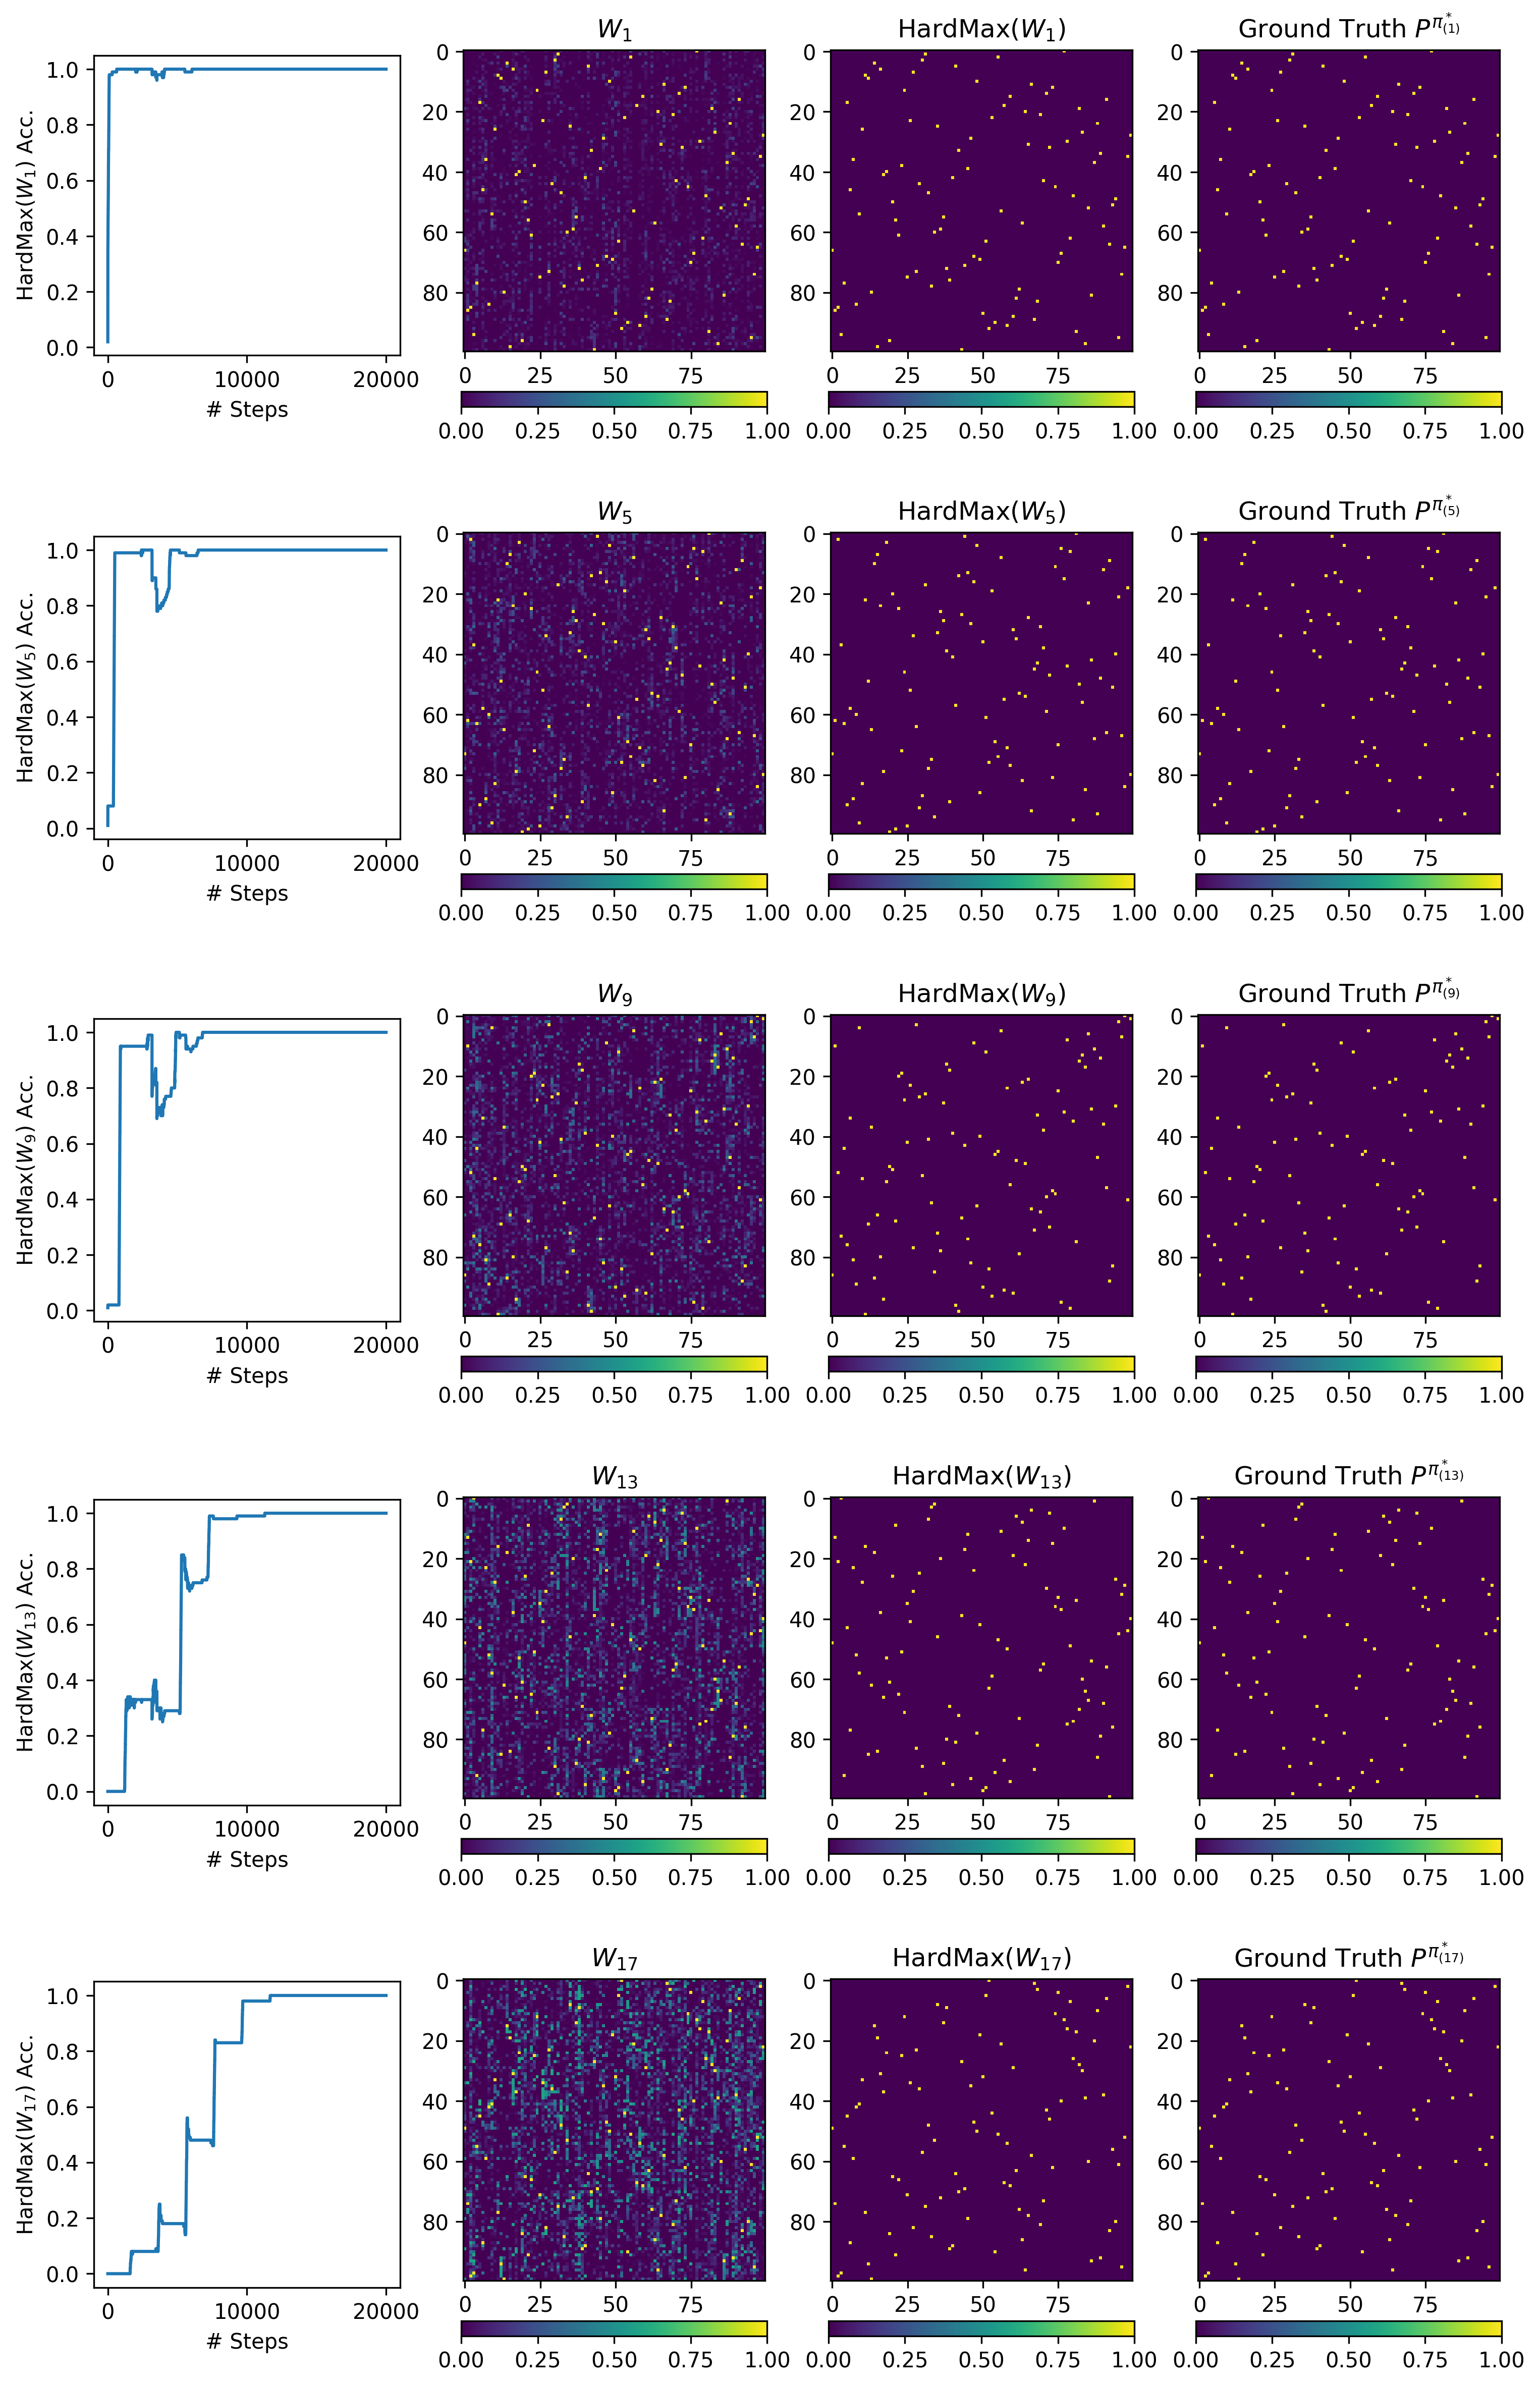

In [30]:
stepsize = 4
plt.figure(figsize=(12, 4*D // stepsize), dpi=300)
gs = gridspec.GridSpec(D // stepsize, 4)
for pi, i in enumerate(range(0, D, stepsize)):

    ax = plt.subplot(gs[pi, 0])
    ax.set_aspect(20000 ,adjustable='box')
    ax.plot(weight_acc[i], label="Layer %d" % i)
    ax.set_ylabel(r"HardMax($W_{{XXX}}$) Acc.".replace("XXX", str(i + 1)))
    ax.set_xlabel("# Steps")
    pos = ax.get_position()  # Get current position
    ax.set_position([pos.x0, pos.y0 + 0.015, pos.width, pos.height])  # Adjust y0

    ax = plt.subplot(gs[pi, 1])
    ax.set_title(r"$W_{{XXX}}$".replace("XXX", str(i + 1)))
    im = ax.imshow(weight_dicts[i].detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

    ax = plt.subplot(gs[pi, 2])
    ax.set_title(r"HardMax($W_{{XXX}}$)".replace("XXX", str(i + 1)))
    im = ax.imshow(torch.softmax(100*weight_dicts[i], dim=1).detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

    ax = plt.subplot(gs[pi, 3])
    ax.set_title(r"Ground Truth $P^{\pi^*_{(XXX)}}$".replace("XXX", str(i + 1)))
    im = ax.imshow(translations[i].detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)


# plt.tight_layout()
plt.savefig("./figs/N10D20L1000_fullparam.pdf", bbox_inches='tight', pad_inches=0)



# plt.figure(figsize=(10, 3.5))
# plt.subplot(1, 3, 1)
# plt.title("Ground Truth")
# plt.imshow(translations[0].detach().cpu().numpy())
# plt.colorbar()
# plt.subplot(1, 3, 2)
# plt.title("Weight")
# plt.imshow(weight_dict1.detach().cpu().numpy())
# plt.colorbar()
# plt.subplot(1, 3, 3)
# plt.title("Effective Matrix")
# plt.imshow(F.softmax(10 * (weight_dict1), dim=0).detach().cpu().numpy())
# plt.colorbar()
plt.show()
